In [1]:
import sys
import os
sys.path.append('../dbm_evaluation')
sys.path.append('../DeepView')

from map_evaluation import P_wrapper, Evaluator, NNinv_keras, NNinv_torch, MapBuilder


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
# import make blobs
from sklearn.datasets import make_blobs

# date
from datetime import datetime

from umap import UMAP

from tqdm import tqdm

from ssnp import SSNP

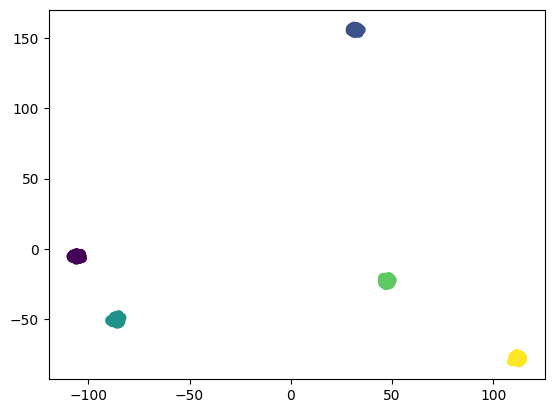

In [2]:
# import PCA
from sklearn.decomposition import PCA

blob = make_blobs(n_samples=1000, n_features=1000, centers=5, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=1)
pca = PCA(n_components=2)
pca.fit(blob[0])
pca_blob = pca.transform(blob[0])

plt.scatter(pca_blob[:,0], pca_blob[:,1], c=blob[1], cmap='viridis')

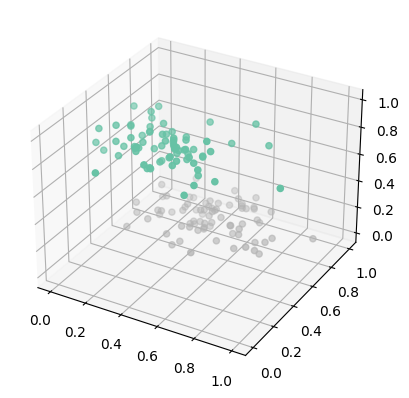

In [3]:
# %matplotlib widget
blob0 = make_blobs(n_samples=150, n_features=3, centers=2, cluster_std=1.0, random_state=666)
# blob0 = make_blobs(n_samples=150, n_features=3, centers=5, cluster_std=1.2, random_state=6666)
y = blob0[1]
# plot the blobs in 3D"
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')
# ax.view_init() what is the default view? type help(ax.view_init)
# help(ax.view_init)
CMAP = 'Set2'
pinot_clor_map = cm.get_cmap(CMAP)
ponit_clor = pinot_clor_map(y/y.max())

#####
lazy_scaler = MinMaxScaler()
blob0 = list(blob0)
blob0[0] = lazy_scaler.fit_transform(blob0[0])
#####

ax_3d.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=ponit_clor, )#cmap='tab10', )

In [4]:
class Simple_P_wrapper:
    def __init__(self, P, Pinv):
        self.P = P
        self.Pinv = Pinv
    def __call__(self, x):
        return self.P(x)
    def transform(self, x):
        return self.P.transform(x)
    def inverse_transform(self, x):
        return self.Pinv.transform(x)

    def fit(self, x, y=None, clf=None):
        self.P.fit(x)
        self.Pinv.fit(self.P.transform(x), x )
        return self

p = UMAP(n_components=2, random_state=43, n_neighbors=30, min_dist=0.9)
Pinv = NNinv_torch(dims=[2048]*4)
proj = Simple_P_wrapper(p, Pinv)

device:  cuda:0


In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(blob0[0])
# X = blob0[0]
y = blob0[1]

NNinv_keras = 0
NNinv_torch = 1
deepview = 0
ssnp = 0

name_list = ['NNinv_keras', 'NNinv_torch', 'deepview', 'ssnp']
#get the none zero name
name_plot = [name_list[i] for i in [NNinv_keras, NNinv_torch, deepview, ssnp] if i != 0][0]

# ssnp = SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0)
proj = P_wrapper(NNinv_Keras=NNinv_keras, NNinv_Torch=NNinv_torch, deepview=deepview, ssnp=ssnp)
clf = linear_model.LogisticRegression()
clf = SVC(probability=True)
# clf = RandomForestClassifier()
dbm = P_wrapper(NNinv_Torch=1, deepview=0, ssnp=0, NNinv_Keras=0)
ssnp = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=0, ssnp=1)
DV = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=1, ssnp=0)


clf.fit(X, y)

DV.fit(X, y, clf, lam=0.65)
dbm.fit(X, y, clf)
ssnp.fit(X, y, clf)


100%|██████████| 150/150 [00:00<00:00, 1114.74it/s]


updating matrices
(0,) (150, 150)
discr 0.0002231597900390625
(0,) (150, 150)
fitting mapper
transforming
fitting inverse
done
fitting time:  0.7969262599945068
device:  cuda:0
Early stopping at epoch 86
fitting time:  0.8935270309448242
device:  /device:GPU:0
fitting time:  2.866185188293457


2.866185188293457

calculating probability map
calculating gradient map
1.1399626


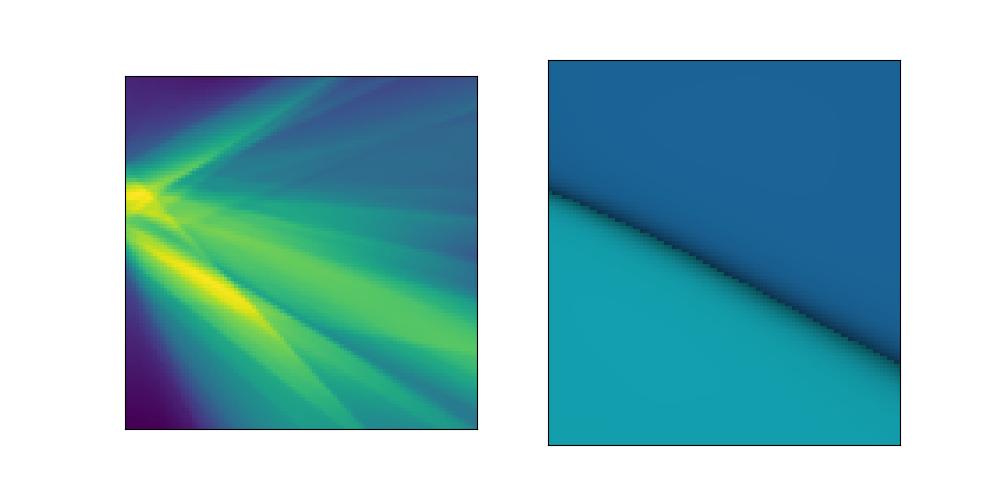

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
map_builder = MapBuilder(clf, ssnp, X, y, grid=100)
ax_grad = map_builder.plot_gradient_map(ax=ax1)
dv_map = map_builder.plot_prob_map(ax=ax2)
plt.show()

[]

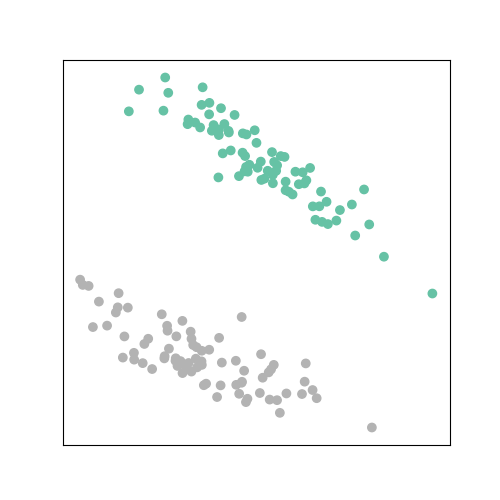

In [16]:
X_2d = ssnp.transform(blob0[0])
# scale the data to be between 0 and 1
# scaler2d = MinMaxScaler()
# X_2d = scaler2d.fit_transform(X_2d)


fig, ax = plt.subplots(figsize=(5,5) )
ax.scatter(X_2d[:,0], X_2d[:,1], c=ponit_clor)
# no ticks
ax.set_xticks([])
ax.set_yticks([])
# suqare aspect ratio`
# ax.set_aspect('equal')
# make directory if it doesn't exist
# if not os.path.exists('./figures/inlustrate_dbm'):
#     os.makedirs('./figures/inlustrate_dbm')
# fig.savefig('./figures/inlustrate_dbm/2d_1')

In [31]:
%matplotlib widget
GRID = 100
# CMAP = 'tab10'


In [32]:
def plot_inverse_map(P_inv, GRID=GRID, clf=clf, ax=None, CMAP=CMAP):

    

    
    X_2d = P_inv.transform(blob0[0])


    xx, yy = np.meshgrid(np.linspace(X_2d[:,0].min(), X_2d[:,0].max(), GRID), np.linspace(X_2d[:,1].min(), X_2d[:,1].max(), GRID))
    XY = np.c_[xx.ravel(), yy.ravel()]
    XY_3d = P_inv.inverse_transform(XY)
    XY_3d = scaler.inverse_transform(XY_3d)
    labels = clf.predict(XY_3d)
    ## grids with labels
    tab10 = cm.get_cmap(CMAP)
    labels_color = tab10(labels/labels.max())
    labels_color_2d = tab10(labels.reshape(GRID,GRID)/labels.max())
    # set alpha to 0.5
    labels_color_2d[:, : ,3] = 0.95
    print(labels_color_2d.shape)
    print(XY_3d[:,0].reshape(GRID,GRID).shape)
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # visual_scaler = MinMaxScaler(0, GRID)

    # # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    # ax.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=blob0[1], cmap='tab10', ec='k', s=7, linewidth=0.1, alpha=0.75)

    # # ax_grid_dbm.plot_wireframe(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), colors=labels_color, alpha=0.5,)
    # ax.plot_surface(
    #     XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
    #       linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    ########################### volume version plot##########
        # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    scatter2plot = blob0[0] * GRID
    ax.scatter(scatter2plot[:,0], scatter2plot[:,1], scatter2plot[:,2], c=blob0[1], cmap=CMAP, ec='k', s=7, linewidth=0.1, alpha=0.75)

    XY_3d *= GRID
    ax.plot_surface(
        XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
          linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    # ratio = 0.1
    # ax.set_xlim(blob0[0][:,0].min()+ratio, blob0[0][:,0].max()*.9)
    # ax.set_ylim(blob0[0][:,1].min()+ratio, blob0[0][:,1].max()*.9)
    # ax.set_zlim(blob0[0][:,2].min()+ratio, blob0[0][:,2].max()*.9)
    # # Make panes transparent
    ax.xaxis.pane.fill = False # Left pane
    ax.yaxis.pane.fill = False # Right pane
    ax.zaxis.pane.fill = False # Right pane

    # Remove grid lines
    ax.grid(False)

    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Transparent spines
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Transparent panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    # backgroud color
    ax.set_facecolor((0.95, 0.95, 0.95, 0.0))

# plot_inverse_map(dbm)
# plt.show()

In [33]:
def check_neigher_label(ind, cube, target=1, margin=GRID):
    # cube = cube.reshape(GRID, GRID, GRID)
    i, j, k = ind
    
    #  list of 6 neighbors
    neighbors = [(i+1, j, k), (i-1, j, k), (i, j+1, k), (i, j-1, k), (i, j, k+1), (i, j, k-1)]
    # check if the neighbors are in the cube
    neighbors = [n for n in neighbors if n[0] >= 0 and n[0] < GRID and n[1] >= 0 and n[1] < GRID and n[2] >= 0 and n[2] < GRID]

    # check if the neighbors are target
    neighbors = [n for n in neighbors if cube[n] == target]

    if len(neighbors) > 0:
        return True


def plot_volume(clf, ax=None, grid=GRID, CMAP=CMAP):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    xx, yy, zz = np.meshgrid(np.linspace(blob0[0][:,0].min(), blob0[0][:,0].max(), grid),
                                np.linspace(blob0[0][:,1].min(), blob0[0][:,1].max(), grid),
                                np.linspace(blob0[0][:,2].min(), blob0[0][:,2].max(), grid))
    
    XYZ = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    labels = clf.predict(XYZ)
    cmap = cm.get_cmap(CMAP)

    labels_color = cmap(labels/labels.max())
    labels_color_3d = labels_color.reshape(grid, grid, grid, 4)
    labels_color_3d[:, :, :, 3] = 0.5

    voxels = np.ones((grid, grid, grid), dtype=bool)

    ax.voxels(voxels, facecolors=labels_color_3d, linewidth=0.1, alpha=0.4, shade=False) #edgecolor='k', 
  
    ##### find the boundary (surface) of the voxels, then plot the surface

    # find all label 0 voxels whose at least one of its 6 neighbors is label 1
    # # find all label 1 voxels whose at least one of its 6 neighbors is label 0

    # ind_0 = np.where(labels == 0)[0]
    # ind_1 = np.where(labels == 1)[0]

    # find the 6 neighbors of each voxel
    # for each voxel, find the index of its 6 neighbors
    boudary_voxels = []
    label_cube = labels.reshape(grid, grid, grid)
    for i in range(GRID):
        for j in range(GRID):
            for k in range(GRID):
                if label_cube[i,j,k] == 0:
                    if check_neigher_label((i,j,k), label_cube, target=1):
                        boudary_voxels.append((i,j,k))
                # elif labels[i,j,k] == 1:
                #     if check_neigher_label((i,j,k), labels, target=0):
                #         boudary_voxels.append((i,j,k))
    boudary_voxels = np.array(boudary_voxels)

    # plot the surface

    ax.scatter(boudary_voxels[:,0], boudary_voxels[:,1], boudary_voxels[:,2], c='k', s=0.5, alpha=0.5)
    #### plot the surface with trisurf
    ax.plot_trisurf(boudary_voxels[:,0], boudary_voxels[:,1], boudary_voxels[:,2], color='r', edgecolor='none', alpha=0.5, antialiased=True)

    # ax.plot_trisurf



    return ax


<Axes3DSubplot: >

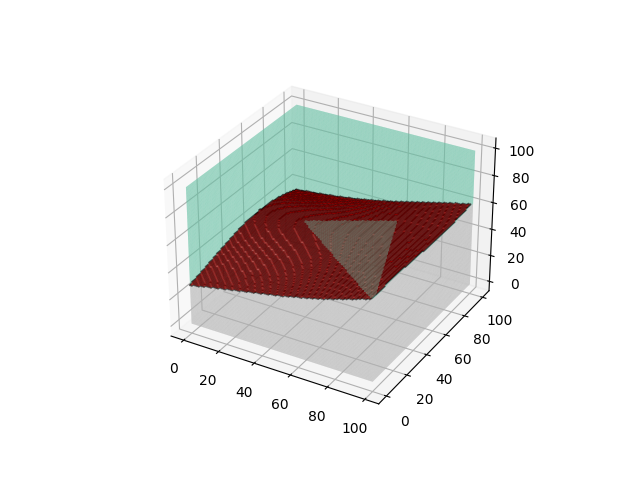

In [34]:
plot_volume(clf)

/tmp/ipykernel_23743/1046912624.py:64: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:65: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:66: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:69: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:70: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplot

(8, 8, 4)
(8, 8)
(8, 8, 4)
(8, 8)


100%|██████████| 150/150 [00:00<00:00, 1382.40it/s]


(8, 8, 4)
(8, 8)


/tmp/ipykernel_23743/1046912624.py:64: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:65: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:66: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:69: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_23743/1046912624.py:70: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplot

Text(0.5, 0.92, 'DeepView')

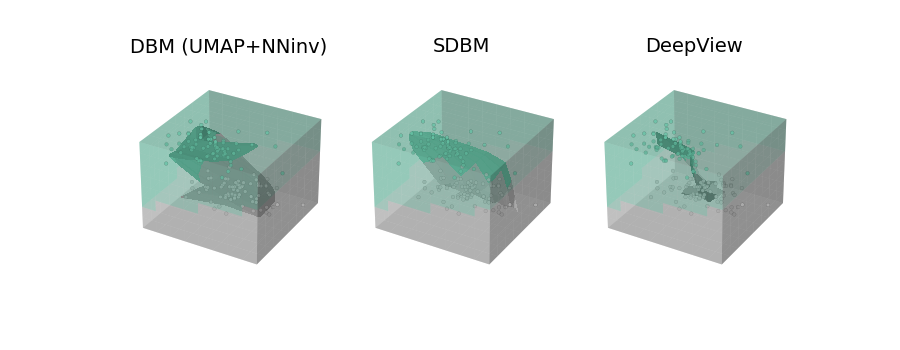

In [12]:
# build a fig with 3 3d-axes
fig = plt.figure(figsize=(9,3.5))
ax1 = fig.add_subplot(131, projection='3d', )
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# white space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

plot_inverse_map(dbm, ax=ax1)
plot_inverse_map(ssnp, ax=ax2)
plot_inverse_map(DV, ax=ax3)

# plot the volume
plot_volume(clf, ax=ax1)
plot_volume(clf, ax=ax2)
plot_volume(clf, ax=ax3)



## set view angle
# viual_angle = (44, -44, 20)
# ax1.view_init(*viual_angle)
# ax2.view_init(*viual_angle)
# ax3.view_init(*viual_angle)

ax1.set_title('DBM (UMAP+NNinv)', fontsize=14)
ax2.set_title('SDBM', fontsize=14)
ax3.set_title('DeepView', fontsize=14)

# fig.savefig('./figures/3d_all.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('../DecisionMap_Comapre_manuscript/figures/demo3d_new.pdf', dpi=300, bbox_inches='tight')

In [12]:
# %matplotlib qt

In [13]:
# # use vispy to create a 3d mesh with color for X_3d and labels

# import vispy
# from vispy import app, scene
# from vispy.scene import visuals
# from vispy.visuals.transforms import STTransform

# # Create canvas
# canvas = scene.SceneCanvas(keys='interactive', show=True)
# # canvas.size = 800, 600
# canvas.show()

# # Create a ViewBox to display the cube with interactive arcball
# view = canvas.central_widget.add_view()
# view.camera = 'turntable'  # or try 'arcball'
# # white background
# view.bgcolor = [.8, .8, .8, 1]


# # Add a colored 3D axis for orientation
# # axis = scene.visuals.XYZAxis(parent=view.scene)

# ## plot blob as small spheres
# print(type(blob0[0]))
# vis = scene.visuals.Markers(
#     pos=blob0[0],
#     size=10,
#     antialias=0,
#     face_color=ponit_clor,
#     edge_color='white',
#     edge_width=0,
#     # scaling=True,
#     # spherical=True,
# )
# vis.parent = view.scene

# ## plot vertices as small spheres
# print(type(XY_3d))
# gridnd = scene.visuals.Markers(
#     pos=XY_3d,
#     size=10,
#     antialias=0,
#     face_color='black',
#     edge_color='white',
#     edge_width=0,
#     scaling=False,
    
#     # spherical=True,  
# )

# gridnd.parent = view.scene

# gridnd_labeled = scene.visuals.Markers(
#     pos=XY_3d,
#     size=10,
#     antialias=0,
#     face_color=labels_color,
#     edge_color='white',
#     edge_width=0,
#     scaling=False,
    
#     # spherical=True,  
# )
# gridnd_labeled.parent = None


# # turn the 3d points into a faces
# faces = []
# for i in range(0, GRID-1, 2):
#     for j in range(0, GRID-1, 2):
#         faces.append([i, i+1, j, j+1])
   
# # create the mesh
# # mesh = vispy.visuals.surface_plot.SurfacePlotVisual(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID))
# mesh = visuals.SurfacePlot(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), parent=view.scene) #, shading='flat'
# # add the mesh to the view
# # view.add(mesh)
# # (vertices=XY_3d.reshape(GRID, GRID, 3), parent=view.scene,)

# mesh2 = visuals.SurfacePlot(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), parent=view.scene) #, shading='flat'
# mesh3 = visuals.SurfacePlot(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), parent=view.scene) #, shading='flat'

# ## surface
# # mesh = scene.visuals.Mesh(XY_3d.reshape(GRID,GRID,3),  parent=view.scene)
# # set color vertices color to labels and set face color to None
# color_to_plot = [id_color,  labels_color, grads_color]
# for i in range(3):
#     # color_to_plot[i] = color_to_plot[i].reshape(GRID,GRID,4)
#     color_to_plot[i][:,3] = 0.9

# # set ahpha to 0.5
# # color_to_plot[:,3] = 0.7

# cur_ind = 0
# mesh.mesh_data.set_vertex_colors(color_to_plot[0])
# mesh2.mesh_data.set_vertex_colors(color_to_plot[1])
# mesh3.mesh_data.set_vertex_colors(color_to_plot[2])



# #draw the mesh by draw lines
# lines = []
# for h_line in XY_3d.reshape(GRID,GRID,3):
#     hline = scene.visuals.Line(pos=h_line, color='k', parent=view.scene, width=3)
#     lines.append(hline)
# for v_line in XY_3d.reshape(GRID,GRID,3).transpose(1,0,2):
#     vmesh = scene.visuals.Line(pos=v_line, color='k', parent=view.scene, width=3)
#     lines.append(vmesh)

# ## draw a axis to show the space better
# # axis = scene.visuals.XYZAxis(parent=view.scene) 
# scene.visuals.GridLines(parent=view.scene)
# ## draw 3 palnes of mesh mannually to show the space better
# # plane = scene.visuals.Plane(parent=view.scene, width=10, height=10, color='k', edge_color='k', edge_width=1)
# # plane.transform = STTransform(translate=(0, 0, 0))



# # # camera center on the mesh
# view.camera.center = mesh.mesh_data.get_vertices().mean(axis=0)
# # alpha = 0.5

# # # mesh.mesh_data.set_face_colors([[0,0,0,0]]*1152)
# # face = np.array(mesh.mesh_data.get_faces())
# # ver = np.array(mesh.mesh_data.get_vertices())
# # print(mesh.mesh_data.get_faces())
# # print(mesh.mesh_data.get_vertices().shape)
# # # mesh.shading = 'flat'

# ## key press event
# def on_key_press(event):
#     if event.key == 's':
#         mesh.shading = 'smooth' if mesh.shading == 'flat' else 'flat'
#         mesh2.shading = 'smooth' if mesh2.shading == 'flat' else 'flat'
#         mesh3.shading = 'smooth' if mesh3.shading == 'flat' else 'flat'
#         canvas.update()
#     # if event.key == 'n': shade = 'none'
#     if event.key == 'n':
#         mesh.shading = None
#         mesh2.shading = None
#         mesh3.shading = None
#         canvas.update()
    
#     if event.key == 'c':
#         # if gridnd color is black, set it to labels_color; else set it to black
#         if gridnd.parent is None:
#             gridnd.parent = view.scene
#             gridnd_labeled.parent = None
#         else:
#             gridnd.parent = None
#             gridnd_labeled.parent = view.scene

#     if event.key == ' ':
#         if mesh.parent is None:
#             mesh.parent = view.scene
#             for l in lines:
#                 l.parent = view.scene
#         else:
#             mesh.parent = None
#             for l in lines:
#                 l.parent = None   
#         canvas.update()

#     if event.key == 'Right':
#         # print('Right')
#         global cur_ind
#         cur_ind = (cur_ind + 1) % len(color_to_plot)
        
#         mesh.mesh_data.set_vertex_colors(color_to_plot[cur_ind])
#         print(cur_ind)
#         canvas.update()
        
#     if event.key == '1':
#         mesh.parent = view.scene
#         mesh2.parent = None
#         mesh3.parent = None
#     if event.key == '2':
#         mesh.parent = None
#         mesh2.parent = view.scene
#         mesh3.parent = None
#     if event.key == '3':
#         mesh.parent = None
#         mesh2.parent = None
#         mesh3.parent = view.scene
#     # if o , save image
#     if event.key == 'o':
#         image = canvas.render( )
#         ## save image at ./figures/inlustrate_dbm/test.png
#         date = datetime.now()
#         # save_name = name_plot + date
#         save_name = name_plot + str(date.year) + str(date.month) + str(date.day) + str(date.hour) + str(date.minute) + str(date.second)
#         vispy.io.write_png('./figures/inlustrate_dbm/' + save_name + '.png', image)
#         print('=====image saved at ./figures/inlustrate_dbm/' + save_name + '.png')
    
#     # if p , take a screenshot
#     if event.key == 'j':
#         vispy.io.write_png("./figures/inlustrate_dbm/3d_1.png", vispy.gloo.util._screenshot((0, 0, canvas.size[0], canvas.size[1])))
#         print("=====png written")
#     if event.key == 'k':
#         vispy.io.write_png("./figures/inlustrate_dbm/3d_2.png", vispy.gloo.util._screenshot((0, 0, canvas.size[0], canvas.size[1])))
#         print("=====png written")
#     if event.key == 'l':
#         vispy.io.write_png("./figures/inlustrate_dbm/3d_3.png", vispy.gloo.util._screenshot((0, 0, canvas.size[0], canvas.size[1])))
#         print("=====png written")

#     ## use up and down to change the alpha of the both mesh
#     # if event.key == 'Up':
#     #     # nonlocal alpha
#     #     alpha = color_to_plot[0][0][3]
#     #     alpha = alpha + 0.1
#     #     if alpha > 1:
#     #         alpha = 1
#     #     color_to_plot[0][:,3] = alpha
#     #     color_to_plot[1][:,3] = alpha
#     #     mesh.mesh_data.set_vertex_colors(color_to_plot[0])
#     #     mesh2.mesh_data.set_vertex_colors(color_to_plot[1])
#     #     canvas.update()
#     # if event.key == 'Down':
#     #     alpha = color_to_plot[0][0][3]
#     #     # nonlocal alpha
#     #     alpha = alpha - 0.1
#     #     if alpha < 0:
#     #         alpha = 0
#     #     color_to_plot[0][:,3] = alpha
#     #     color_to_plot[1][:,3] = alpha
#     #     mesh.mesh_data.set_vertex_colors(color_to_plot[0])
#     #     mesh2.mesh_data.set_vertex_colors(color_to_plot[1])
#     #     canvas.update()

# if __name__ == '__main__' and sys.flags.interactive == 0:
#     canvas.events.key_press.connect(on_key_press)
#     ##squre the window 
#     # canvas.size = 1000, 1000
#     app.run()
